# 8章 MNISTを使った数字認識

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm


/home/sota/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38306 (\N{CJK UNIFIED IDEOGRAPH-95A2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sota/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


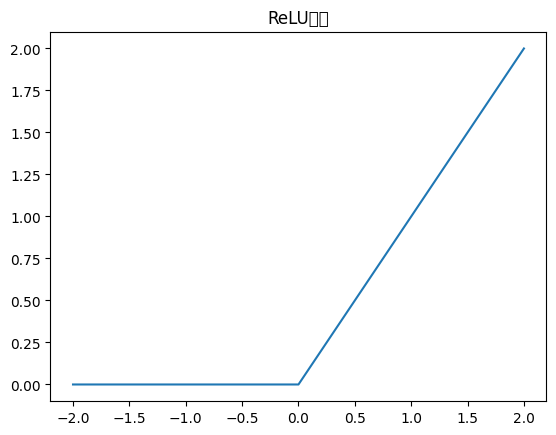

In [172]:
relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x    = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()

In [173]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)# cudaが利用可能だと0

cuda:0


## 8.8 データ準備1(データセットによる読み込み)

In [174]:
data_root = './data'
train_set0 = datasets.MNIST(
    root = data_root,
    train = True,
    download = True
)
!ls -lR ./data/MNIST

150134.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


./data/MNIST:
total 4
drwxrwxr-x 2 sota sota 4096 12月 22 23:12 raw

./data/MNIST/raw:
total 65012
-rw-rw-r-- 1 sota sota  7840016 12月 22 23:12 t10k-images-idx3-ubyte
-rw-rw-r-- 1 sota sota  1648877 12月 22 23:12 t10k-images-idx3-ubyte.gz
-rw-rw-r-- 1 sota sota    10008 12月 22 23:12 t10k-labels-idx1-ubyte
-rw-rw-r-- 1 sota sota     4542 12月 22 23:12 t10k-labels-idx1-ubyte.gz
-rw-rw-r-- 1 sota sota 47040016 12月 22 23:12 train-images-idx3-ubyte
-rw-rw-r-- 1 sota sota  9912422 12月 22 23:12 train-images-idx3-ubyte.gz
-rw-rw-r-- 1 sota sota    60008 12月 22 23:12 train-labels-idx1-ubyte
-rw-rw-r-- 1 sota sota    28881 12月 22 23:12 train-labels-idx1-ubyte.gz


In [175]:
print("データ件数：", len(train_set0))
image, label = train_set0[0]
print("入力データの型：", type(image))
print("正解データの型：", type(label))

データ件数： 60000
入力データの型： <class 'PIL.Image.Image'>
正解データの型： <class 'int'>


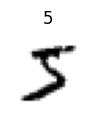

In [176]:
plt.figure(figsize=(1,1))
plt.title(f'{label}')
plt.imshow(image, cmap="gray_r")
plt.axis("off")
plt.show()

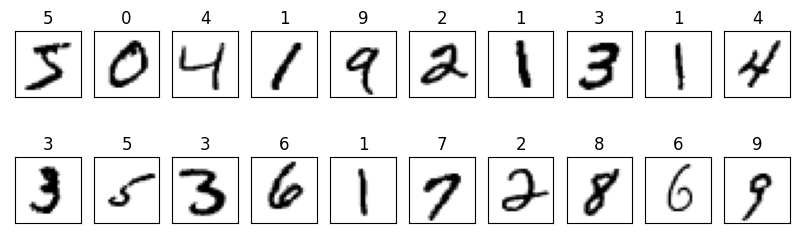

In [177]:
plt.figure(figsize=(10,3))
for i in range(20):
    ax = plt.subplot(2,10,i+1)
    image, label = train_set0[i]
    plt.imshow(image, cmap="gray_r")
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 8.9 データ準備2(Transformsによるデータ前処理)

In [178]:
# ToTensor：入力データの形式をPyTorchで扱えるテンソル形式に変換する
transform1 = transforms.Compose([
    transforms.ToTensor(),
])
train_set1 = datasets.MNIST(
    root=data_root, 
    train=True, 
    download=True,
    transform = transform1
)

In [179]:
image, label = train_set1[0]
print("入力データの型：", type(image))
print("入力データのshape：", image.shape)
print("Min: ", image.data.min())
print("Max: ", image.data.max())

入力データの型： <class 'torch.Tensor'>
入力データのshape： torch.Size([1, 28, 28])
Min:  tensor(0.)
Max:  tensor(1.)


In [180]:
# データの範囲を[-1, 1]になるように正規化
# Normalize:X=(x-u)/σ（u=σ=0.5)
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root = data_root, 
    train=True, 
    download=True, 
    transform=transform2
)

image, label = train_set2[0]
print("入力データの型：", type(image))
print("入力データのshape：", image.shape)
print("Min: ", image.data.min())
print("Max: ", image.data.max())

入力データの型： <class 'torch.Tensor'>
入力データのshape： torch.Size([1, 28, 28])
Min:  tensor(-1.)
Max:  tensor(1.)


In [181]:
# Lambdaクラスを利用して１次元化
# テンソルではreshapeではなく、viewを用いる
transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root, 
    train=True, 
    download=True, 
    transform=transform3
)

image, label = train_set3[0]
print("入力データの型: ", type(image))
print("入力データのshape: ", image.shape)
print("Min: ", image.data.min())
print("Max: ", image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([784])
Min:  tensor(-1.)
Max:  tensor(1.)


In [182]:
# 最終的なデータセットの定義
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])
train_set = datasets.MNIST(
    root = data_root, train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    root = data_root, train=False, download=True, transform=transform
)

## 8.10 データ準備3(データローダによるミニバッチ用データ生成)

In [183]:
from torch.utils.data import DataLoader
batch_size=500

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False
)

In [184]:
print(len(train_loader))
for images, labels in train_loader:
    break
print(len(labels))
print(images.shape)
print(labels.shape)

120
500
torch.Size([500, 784])
torch.Size([500])


## 8.11 モデル定義

In [185]:
n_input = image.shape[0]
n_output = len(set(list(labels.data.numpy())))
n_hidden = 128
print(f'n_input: {n_input} n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784 n_hidden: 128 n_output: 10


In [186]:
# モデルの定義
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3


In [187]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)

net = Net(n_input, n_output, n_hidden)
net = net.to(device)
# net = Net(n_input, n_output, n_hidden).to(device)

In [188]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [189]:
for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [190]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


## 8.12 勾配降下法

In [191]:
for images, labels in train_loader:
    break
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
print(outputs)

tensor([[-0.2908, -0.0540,  0.0845,  ...,  0.0779,  0.1828,  0.1080],
        [-0.2764, -0.3271, -0.1788,  ...,  0.1037,  0.1030, -0.0235],
        [-0.3289, -0.0409,  0.1447,  ...,  0.3945,  0.2317,  0.1213],
        ...,
        [-0.4067, -0.0062,  0.1470,  ...,  0.0346,  0.1045,  0.1304],
        [-0.3684, -0.2211,  0.1907,  ...,  0.0544,  0.2114,  0.1275],
        [-0.2524, -0.2597,  0.1427,  ...,  0.0983,  0.1258,  0.0972]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


2.3259596824645996


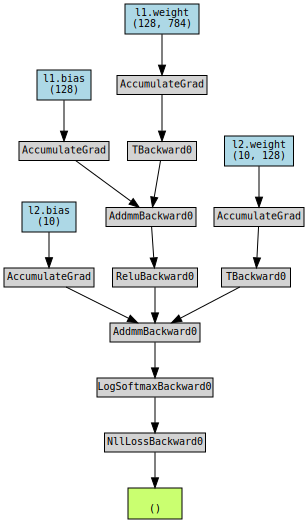

In [192]:
# 損失計算
loss = criterion(outputs, labels)
print(loss.item())
make_dot(loss, params=dict(net.named_parameters()))

In [193]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = 0.01
# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)
# 損失関数：交差エントロピー関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=lr)
# 繰り返し回数
num_epochs = 100
# 評価関数結果記録用
history = np.zeros((0,5))


In [194]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)
        # GPUへ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 勾配の初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = net(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配計算
        loss.backward()
        # パラメータ修正
        optimizer.step()
        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]
        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    # 予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失関数
        loss_test = criterion(outputs_test, labels_test)

        # 予測データ導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と制度の計算
        val_loss += loss_test.item()
        val_acc += (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))
print(f'初期状態：損失：{history[0,3]:.5f}  精度：{history[0,4]:.5f}')
print(f'最終状態：損失：{history[-1,3]:.5f}  精度：{history[-1,4]:.5f}')

100%|██████████| 120/120 [00:03<00:00, 37.81it/s]


Epoch [1/100], loss: 1.82932 acc: 0.56960 val_loss: 1.32629, val_acc: 0.74660


100%|██████████| 120/120 [00:03<00:00, 37.22it/s]


Epoch [2/100], loss: 1.03889 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


100%|██████████| 120/120 [00:03<00:00, 37.54it/s]


Epoch [3/100], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


100%|██████████| 120/120 [00:03<00:00, 36.87it/s]


Epoch [4/100], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


100%|██████████| 120/120 [00:03<00:00, 37.78it/s]


Epoch [5/100], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87930


100%|██████████| 120/120 [00:03<00:00, 37.41it/s]


Epoch [6/100], loss: 0.45883 acc: 0.87877 val_loss: 0.42422, val_acc: 0.88650


100%|██████████| 120/120 [00:03<00:00, 37.28it/s]


Epoch [7/100], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


100%|██████████| 120/120 [00:03<00:00, 36.61it/s]


Epoch [8/100], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


100%|██████████| 120/120 [00:03<00:00, 37.24it/s]


Epoch [9/100], loss: 0.39176 acc: 0.89065 val_loss: 0.36857, val_acc: 0.89680


100%|██████████| 120/120 [00:03<00:00, 36.80it/s]


Epoch [10/100], loss: 0.37875 acc: 0.89315 val_loss: 0.35741, val_acc: 0.89930


100%|██████████| 120/120 [00:03<00:00, 37.51it/s]


Epoch [11/100], loss: 0.36812 acc: 0.89592 val_loss: 0.34868, val_acc: 0.90160


100%|██████████| 120/120 [00:03<00:00, 37.38it/s]


Epoch [12/100], loss: 0.35909 acc: 0.89783 val_loss: 0.34089, val_acc: 0.90220


100%|██████████| 120/120 [00:03<00:00, 37.20it/s]


Epoch [13/100], loss: 0.35147 acc: 0.89977 val_loss: 0.33336, val_acc: 0.90490


100%|██████████| 120/120 [00:03<00:00, 37.42it/s]


Epoch [14/100], loss: 0.34476 acc: 0.90130 val_loss: 0.32806, val_acc: 0.90570


100%|██████████| 120/120 [00:03<00:00, 36.89it/s]


Epoch [15/100], loss: 0.33860 acc: 0.90310 val_loss: 0.32334, val_acc: 0.90710


100%|██████████| 120/120 [00:03<00:00, 37.52it/s]


Epoch [16/100], loss: 0.33333 acc: 0.90412 val_loss: 0.31806, val_acc: 0.90790


100%|██████████| 120/120 [00:03<00:00, 36.67it/s]


Epoch [17/100], loss: 0.32843 acc: 0.90520 val_loss: 0.31445, val_acc: 0.90930


100%|██████████| 120/120 [00:03<00:00, 37.29it/s]


Epoch [18/100], loss: 0.32380 acc: 0.90700 val_loss: 0.31076, val_acc: 0.91090


100%|██████████| 120/120 [00:03<00:00, 37.38it/s]


Epoch [19/100], loss: 0.31950 acc: 0.90810 val_loss: 0.30586, val_acc: 0.91190


100%|██████████| 120/120 [00:03<00:00, 37.39it/s]


Epoch [20/100], loss: 0.31587 acc: 0.90903 val_loss: 0.30281, val_acc: 0.91230


100%|██████████| 120/120 [00:03<00:00, 36.90it/s]


Epoch [21/100], loss: 0.31199 acc: 0.91030 val_loss: 0.29965, val_acc: 0.91520


100%|██████████| 120/120 [00:03<00:00, 37.53it/s]


Epoch [22/100], loss: 0.30842 acc: 0.91100 val_loss: 0.29713, val_acc: 0.91430


100%|██████████| 120/120 [00:03<00:00, 37.45it/s]


Epoch [23/100], loss: 0.30508 acc: 0.91195 val_loss: 0.29432, val_acc: 0.91570


100%|██████████| 120/120 [00:03<00:00, 37.60it/s]


Epoch [24/100], loss: 0.30191 acc: 0.91322 val_loss: 0.29123, val_acc: 0.91780


100%|██████████| 120/120 [00:03<00:00, 37.56it/s]


Epoch [25/100], loss: 0.29884 acc: 0.91402 val_loss: 0.28884, val_acc: 0.91710


100%|██████████| 120/120 [00:03<00:00, 37.22it/s]


Epoch [26/100], loss: 0.29598 acc: 0.91492 val_loss: 0.28646, val_acc: 0.91820


100%|██████████| 120/120 [00:03<00:00, 37.43it/s]


Epoch [27/100], loss: 0.29312 acc: 0.91658 val_loss: 0.28366, val_acc: 0.91960


100%|██████████| 120/120 [00:03<00:00, 36.44it/s]


Epoch [28/100], loss: 0.29028 acc: 0.91697 val_loss: 0.28186, val_acc: 0.92000


100%|██████████| 120/120 [00:03<00:00, 37.43it/s]


Epoch [29/100], loss: 0.28766 acc: 0.91803 val_loss: 0.28042, val_acc: 0.91970


100%|██████████| 120/120 [00:03<00:00, 36.80it/s]


Epoch [30/100], loss: 0.28511 acc: 0.91862 val_loss: 0.27747, val_acc: 0.92110


100%|██████████| 120/120 [00:03<00:00, 37.37it/s]


Epoch [31/100], loss: 0.28234 acc: 0.91962 val_loss: 0.27485, val_acc: 0.92170


100%|██████████| 120/120 [00:03<00:00, 37.46it/s]


Epoch [32/100], loss: 0.27990 acc: 0.92035 val_loss: 0.27255, val_acc: 0.92110


100%|██████████| 120/120 [00:03<00:00, 37.52it/s]


Epoch [33/100], loss: 0.27764 acc: 0.92070 val_loss: 0.27011, val_acc: 0.92210


100%|██████████| 120/120 [00:03<00:00, 36.79it/s]


Epoch [34/100], loss: 0.27515 acc: 0.92103 val_loss: 0.26898, val_acc: 0.92380


100%|██████████| 120/120 [00:03<00:00, 37.35it/s]


Epoch [35/100], loss: 0.27279 acc: 0.92235 val_loss: 0.26669, val_acc: 0.92450


100%|██████████| 120/120 [00:03<00:00, 37.49it/s]


Epoch [36/100], loss: 0.27049 acc: 0.92277 val_loss: 0.26464, val_acc: 0.92360


100%|██████████| 120/120 [00:03<00:00, 36.63it/s]


Epoch [37/100], loss: 0.26829 acc: 0.92353 val_loss: 0.26281, val_acc: 0.92430


100%|██████████| 120/120 [00:03<00:00, 37.25it/s]


Epoch [38/100], loss: 0.26598 acc: 0.92405 val_loss: 0.26077, val_acc: 0.92560


100%|██████████| 120/120 [00:03<00:00, 37.31it/s]


Epoch [39/100], loss: 0.26358 acc: 0.92450 val_loss: 0.25920, val_acc: 0.92570


100%|██████████| 120/120 [00:03<00:00, 37.42it/s]


Epoch [40/100], loss: 0.26158 acc: 0.92572 val_loss: 0.25721, val_acc: 0.92670


100%|██████████| 120/120 [00:03<00:00, 36.57it/s]


Epoch [41/100], loss: 0.25920 acc: 0.92598 val_loss: 0.25559, val_acc: 0.92620


100%|██████████| 120/120 [00:03<00:00, 37.51it/s]


Epoch [42/100], loss: 0.25716 acc: 0.92692 val_loss: 0.25284, val_acc: 0.92730


100%|██████████| 120/120 [00:03<00:00, 36.81it/s]


Epoch [43/100], loss: 0.25497 acc: 0.92757 val_loss: 0.25101, val_acc: 0.92950


100%|██████████| 120/120 [00:03<00:00, 37.45it/s]


Epoch [44/100], loss: 0.25293 acc: 0.92772 val_loss: 0.24996, val_acc: 0.92790


100%|██████████| 120/120 [00:03<00:00, 37.60it/s]


Epoch [45/100], loss: 0.25097 acc: 0.92843 val_loss: 0.24744, val_acc: 0.92920


100%|██████████| 120/120 [00:03<00:00, 37.44it/s]


Epoch [46/100], loss: 0.24868 acc: 0.92938 val_loss: 0.24637, val_acc: 0.93060


100%|██████████| 120/120 [00:03<00:00, 36.90it/s]


Epoch [47/100], loss: 0.24665 acc: 0.92968 val_loss: 0.24403, val_acc: 0.93100


100%|██████████| 120/120 [00:03<00:00, 37.65it/s]


Epoch [48/100], loss: 0.24464 acc: 0.93037 val_loss: 0.24265, val_acc: 0.93060


100%|██████████| 120/120 [00:03<00:00, 37.09it/s]


Epoch [49/100], loss: 0.24267 acc: 0.93060 val_loss: 0.24011, val_acc: 0.93230


100%|██████████| 120/120 [00:03<00:00, 36.67it/s]


Epoch [50/100], loss: 0.24070 acc: 0.93140 val_loss: 0.23929, val_acc: 0.93250


100%|██████████| 120/120 [00:03<00:00, 37.47it/s]


Epoch [51/100], loss: 0.23872 acc: 0.93212 val_loss: 0.23708, val_acc: 0.93310


100%|██████████| 120/120 [00:03<00:00, 37.51it/s]


Epoch [52/100], loss: 0.23681 acc: 0.93228 val_loss: 0.23567, val_acc: 0.93300


100%|██████████| 120/120 [00:03<00:00, 37.49it/s]


Epoch [53/100], loss: 0.23485 acc: 0.93350 val_loss: 0.23360, val_acc: 0.93320


100%|██████████| 120/120 [00:03<00:00, 36.50it/s]


Epoch [54/100], loss: 0.23295 acc: 0.93442 val_loss: 0.23176, val_acc: 0.93440


100%|██████████| 120/120 [00:03<00:00, 37.46it/s]


Epoch [55/100], loss: 0.23101 acc: 0.93475 val_loss: 0.22988, val_acc: 0.93450


100%|██████████| 120/120 [00:03<00:00, 36.68it/s]


Epoch [56/100], loss: 0.22909 acc: 0.93523 val_loss: 0.22863, val_acc: 0.93470


100%|██████████| 120/120 [00:03<00:00, 37.54it/s]


Epoch [57/100], loss: 0.22729 acc: 0.93570 val_loss: 0.22641, val_acc: 0.93600


100%|██████████| 120/120 [00:03<00:00, 37.27it/s]


Epoch [58/100], loss: 0.22537 acc: 0.93640 val_loss: 0.22547, val_acc: 0.93580


100%|██████████| 120/120 [00:03<00:00, 37.48it/s]


Epoch [59/100], loss: 0.22367 acc: 0.93695 val_loss: 0.22322, val_acc: 0.93580


100%|██████████| 120/120 [00:03<00:00, 37.74it/s]


Epoch [60/100], loss: 0.22190 acc: 0.93745 val_loss: 0.22189, val_acc: 0.93640


100%|██████████| 120/120 [00:03<00:00, 37.42it/s]


Epoch [61/100], loss: 0.22019 acc: 0.93803 val_loss: 0.22010, val_acc: 0.93720


100%|██████████| 120/120 [00:03<00:00, 37.38it/s]


Epoch [62/100], loss: 0.21846 acc: 0.93840 val_loss: 0.21883, val_acc: 0.93770


100%|██████████| 120/120 [00:03<00:00, 36.78it/s]


Epoch [63/100], loss: 0.21654 acc: 0.93902 val_loss: 0.21656, val_acc: 0.93710


100%|██████████| 120/120 [00:03<00:00, 37.60it/s]


Epoch [64/100], loss: 0.21486 acc: 0.93968 val_loss: 0.21576, val_acc: 0.93910


100%|██████████| 120/120 [00:03<00:00, 37.34it/s]


Epoch [65/100], loss: 0.21321 acc: 0.94010 val_loss: 0.21334, val_acc: 0.93830


100%|██████████| 120/120 [00:03<00:00, 37.43it/s]


Epoch [66/100], loss: 0.21152 acc: 0.94048 val_loss: 0.21216, val_acc: 0.93880


100%|██████████| 120/120 [00:03<00:00, 36.74it/s]


Epoch [67/100], loss: 0.20996 acc: 0.94113 val_loss: 0.21143, val_acc: 0.93960


100%|██████████| 120/120 [00:03<00:00, 37.63it/s]


Epoch [68/100], loss: 0.20826 acc: 0.94155 val_loss: 0.20924, val_acc: 0.94000


100%|██████████| 120/120 [00:03<00:00, 37.71it/s]


Epoch [69/100], loss: 0.20674 acc: 0.94212 val_loss: 0.20716, val_acc: 0.94010


100%|██████████| 120/120 [00:03<00:00, 37.57it/s]


Epoch [70/100], loss: 0.20500 acc: 0.94237 val_loss: 0.20682, val_acc: 0.93980


100%|██████████| 120/120 [00:03<00:00, 37.61it/s]


Epoch [71/100], loss: 0.20353 acc: 0.94295 val_loss: 0.20485, val_acc: 0.94070


100%|██████████| 120/120 [00:03<00:00, 37.51it/s]


Epoch [72/100], loss: 0.20198 acc: 0.94350 val_loss: 0.20378, val_acc: 0.94120


100%|██████████| 120/120 [00:03<00:00, 37.49it/s]


Epoch [73/100], loss: 0.20053 acc: 0.94377 val_loss: 0.20210, val_acc: 0.94110


100%|██████████| 120/120 [00:03<00:00, 36.89it/s]


Epoch [74/100], loss: 0.19892 acc: 0.94420 val_loss: 0.20087, val_acc: 0.94240


100%|██████████| 120/120 [00:03<00:00, 37.42it/s]


Epoch [75/100], loss: 0.19754 acc: 0.94452 val_loss: 0.19895, val_acc: 0.94260


100%|██████████| 120/120 [00:03<00:00, 36.65it/s]


Epoch [76/100], loss: 0.19587 acc: 0.94513 val_loss: 0.19793, val_acc: 0.94290


100%|██████████| 120/120 [00:03<00:00, 37.49it/s]


Epoch [77/100], loss: 0.19455 acc: 0.94537 val_loss: 0.19671, val_acc: 0.94330


100%|██████████| 120/120 [00:03<00:00, 37.29it/s]


Epoch [78/100], loss: 0.19313 acc: 0.94565 val_loss: 0.19520, val_acc: 0.94430


100%|██████████| 120/120 [00:03<00:00, 37.22it/s]


Epoch [79/100], loss: 0.19163 acc: 0.94618 val_loss: 0.19405, val_acc: 0.94420


100%|██████████| 120/120 [00:03<00:00, 36.69it/s]


Epoch [80/100], loss: 0.19041 acc: 0.94640 val_loss: 0.19305, val_acc: 0.94350


100%|██████████| 120/120 [00:03<00:00, 37.37it/s]


Epoch [81/100], loss: 0.18891 acc: 0.94720 val_loss: 0.19191, val_acc: 0.94340


100%|██████████| 120/120 [00:03<00:00, 37.46it/s]


Epoch [82/100], loss: 0.18764 acc: 0.94742 val_loss: 0.19040, val_acc: 0.94460


100%|██████████| 120/120 [00:03<00:00, 36.75it/s]


Epoch [83/100], loss: 0.18621 acc: 0.94792 val_loss: 0.18893, val_acc: 0.94580


100%|██████████| 120/120 [00:03<00:00, 37.63it/s]


Epoch [84/100], loss: 0.18488 acc: 0.94815 val_loss: 0.18788, val_acc: 0.94470


100%|██████████| 120/120 [00:03<00:00, 37.48it/s]


Epoch [85/100], loss: 0.18358 acc: 0.94817 val_loss: 0.18693, val_acc: 0.94610


100%|██████████| 120/120 [00:03<00:00, 37.36it/s]


Epoch [86/100], loss: 0.18229 acc: 0.94887 val_loss: 0.18559, val_acc: 0.94620


100%|██████████| 120/120 [00:03<00:00, 36.45it/s]


Epoch [87/100], loss: 0.18102 acc: 0.94948 val_loss: 0.18464, val_acc: 0.94570


100%|██████████| 120/120 [00:03<00:00, 37.25it/s]


Epoch [88/100], loss: 0.17977 acc: 0.94982 val_loss: 0.18369, val_acc: 0.94700


100%|██████████| 120/120 [00:03<00:00, 36.59it/s]


Epoch [89/100], loss: 0.17848 acc: 0.95022 val_loss: 0.18186, val_acc: 0.94690


100%|██████████| 120/120 [00:03<00:00, 37.44it/s]


Epoch [90/100], loss: 0.17738 acc: 0.95042 val_loss: 0.18091, val_acc: 0.94740


100%|██████████| 120/120 [00:03<00:00, 37.49it/s]


Epoch [91/100], loss: 0.17613 acc: 0.95100 val_loss: 0.17955, val_acc: 0.94800


100%|██████████| 120/120 [00:03<00:00, 37.29it/s]


Epoch [92/100], loss: 0.17489 acc: 0.95115 val_loss: 0.17922, val_acc: 0.94780


100%|██████████| 120/120 [00:03<00:00, 36.86it/s]


Epoch [93/100], loss: 0.17384 acc: 0.95143 val_loss: 0.17746, val_acc: 0.94810


100%|██████████| 120/120 [00:03<00:00, 37.29it/s]


Epoch [94/100], loss: 0.17266 acc: 0.95175 val_loss: 0.17637, val_acc: 0.94790


100%|██████████| 120/120 [00:03<00:00, 37.41it/s]


Epoch [95/100], loss: 0.17144 acc: 0.95213 val_loss: 0.17558, val_acc: 0.94900


100%|██████████| 120/120 [00:03<00:00, 36.96it/s]


Epoch [96/100], loss: 0.17037 acc: 0.95277 val_loss: 0.17471, val_acc: 0.94820


100%|██████████| 120/120 [00:03<00:00, 37.16it/s]


Epoch [97/100], loss: 0.16916 acc: 0.95272 val_loss: 0.17390, val_acc: 0.94830


100%|██████████| 120/120 [00:03<00:00, 37.25it/s]


Epoch [98/100], loss: 0.16812 acc: 0.95328 val_loss: 0.17415, val_acc: 0.94830


100%|██████████| 120/120 [00:03<00:00, 37.50it/s]


Epoch [99/100], loss: 0.16697 acc: 0.95352 val_loss: 0.17147, val_acc: 0.94840


100%|██████████| 120/120 [00:03<00:00, 36.58it/s]


Epoch [100/100], loss: 0.16584 acc: 0.95405 val_loss: 0.17069, val_acc: 0.94970
初期状態：損失：1.32629  精度：0.74660
最終状態：損失：0.17069  精度：0.94970


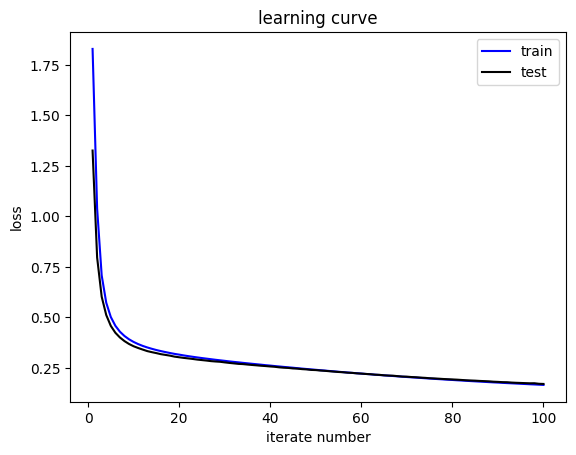

In [195]:
# 学習曲線の表示(損失)
plt.plot(history[:,0], history[:,1], "b", label="train")
plt.plot(history[:,0], history[:,3], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('loss')
plt.title('learning curve')
plt.legend()
plt.show()

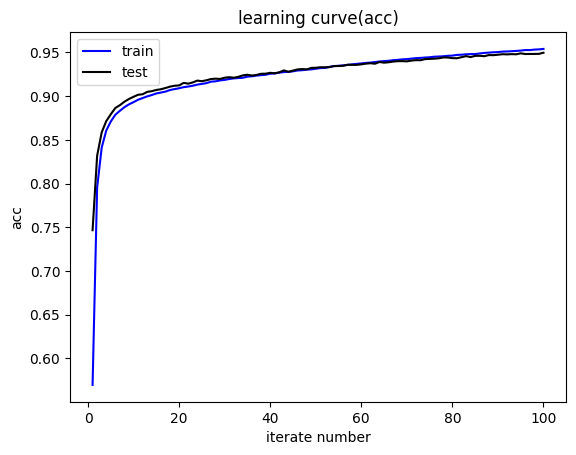

In [196]:
# 学習曲線の表示(精度)
plt.plot(history[:,0], history[:,2], "b", label="train")
plt.plot(history[:,0], history[:,4], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('acc')
plt.title('learning curve(acc)')
plt.legend()
plt.show()